In [4]:
import numpy as np
import pandas as pd
import cv2


from utils import *

## Feature extraction from image
#### Fetures
+ Point of interests in an image
+ Can be found on multiple images

### Feature Detection algorithms
+ Harris (corners) {Harris & Stephans, 1988} - Easy to compute, not scale Invariant
+ Harris-laplass (corners) - Scale selection is based on Laplacian
+ FAST (Features from Accelirated Segment Test, 2006) - ML based fast corner detection algorithm

### Image Features Descriptors
     Descriptor : 
        * N-Dim vector that provide summery of the image information arround the detected frame
        * Invariance to tranformation( Rotation, Translation, scaling)
        * Distinetiveness : We can able to destinguish between two close by features

#### SIFT (Scale Invariant feature Transformer) {1999}
+ 16x16 window around detected frame 
    * Separated into 4 cells -Each comprassed of 4x4 patch of pixel
    * Compute edge orientation of each pixel in the cell
    * Supress edges according to predefined threshold
    * Construct 32-dim histogram of orientation for each cell and then concatenate -> 128 dim descriptor
  
#### Other algorithms
* ORB (Oriented Fast and Rotated Brief)
* SURF (Speeded Up Robust Features)
* BRIEF (Binary Robust Independent Elementary Features)
* GLOH (Gradient Location Orientation Histogram)


In [5]:
import matplotlib.pyplot as plt

In [6]:
def feature_extractor(image,flag='SIFT'):
    if flag=='SIFT':
        sift=cv2.SIFT_create(500)
        kp,des=sift.detectAndCompute(image, None)
        return kp,des
    if flag=='ORB':
        orb=cv2.ORB_create(500)
        kp,des=orb.detectAndCompute(image,None)
        return kp,des
    

In [7]:
def extract_features_dataset(images,extract_function):
    kp_list=[]
    des_list=[]
    for img in images_:
        kp,des=extract_function(img,'SIFT')
        kp_list.append(kp)
        des_list.append(des)
    return kp_list,des_list

In [8]:
img=cv2.imread('kitty.jpg')
img=cv2.resize(img,(int(img.shape[1]/2.5),int(img.shape[0]/2.5)))

In [9]:
img.shape

(1203, 1644, 3)

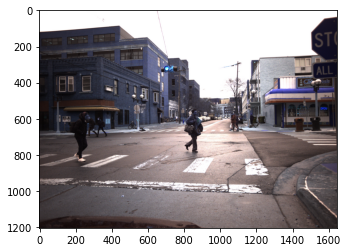

In [10]:
plt.imshow(img)

In [11]:
kp,des=feature_extractor(img,'SIFT')

In [12]:
display=cv2.drawKeypoints(img,kp,None,(0,255,0),4)

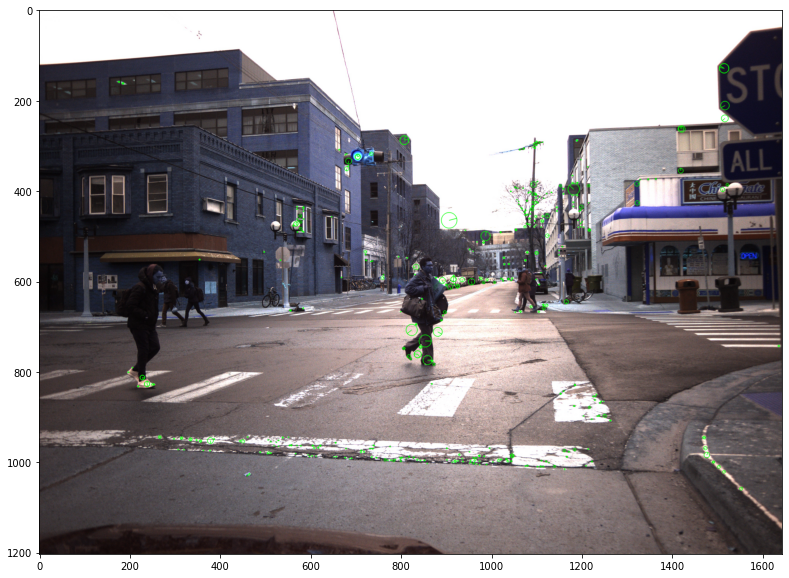

In [13]:
plt.figure(figsize = (20,10))
plt.imshow(display)

In [14]:
folder="C:/Users/eight/Documents/cv lab/Untitled Folder/meyer_green"

In [15]:
images_=read_data_img(folder)

In [16]:
kp_list,des_list=extract_features_dataset(images_,feature_extractor)

## Feature matching
* Brute-Force Matching algorithm
* FLANN Matching algorithm

In [17]:
def BF_matcher(des1,des2):
    bf=cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
    match=bf.knnMatch(np.asarray(des1,np.float32),np.asarray(des2,np.float32),k=2)
    return match

In [18]:
def Flann_matcher(des1,des2):
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    return matches

In [19]:
kp1,des1=feature_extractor(images_[1],'SIFT')
kp2,des2=feature_extractor(images_[2],'SIFT')

In [20]:
matches=Flann_matcher(des1,des2)

In [21]:
img1=images_[1]
img2=images_[2]

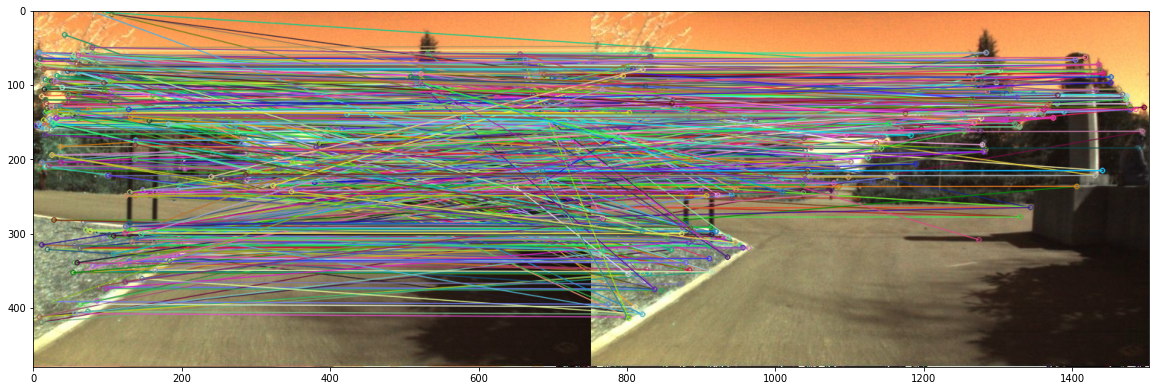

In [22]:
img3=cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=2)
plt.figure(figsize = (20,10))
plt.imshow(img3)
plt.show()

In [23]:
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    
    ### START CODE HERE ###
    for i,(m,n) in enumerate(match):
        if m.distance < dist_threshold*n.distance:
            filtered_match.append(m)
        

    
    ### END CODE HERE ###

    return filtered_match

In [24]:
# Optional
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]
match = Flann_matcher(des1, des2)

dist_threshold = 0.6
filtered_match = filter_matches_distance(match, dist_threshold)

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

Number of features matched in frames 0 and 1 after filtering by distance: 264


In [25]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1,kp1,image2,kp2,filtered_match[:10],None,flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

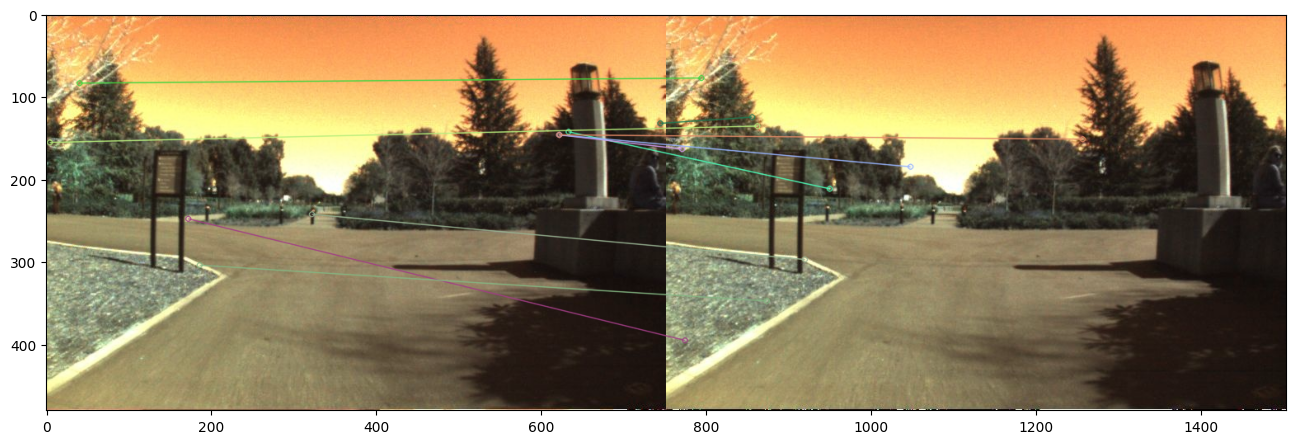

In [26]:
# Visualize n first matches, set n to None to view all matches
# set filtering to True if using match filtering, otherwise set to False
n = 10
filtering = False

i = 0 
image1 = images_[1]
image2 = images_[2]

kp1 = kp_list[1]
kp2 = kp_list[2]

des1 = des_list[1]
des2 = des_list[2]

match = Flann_matcher(des1, des2)
if filtering:
    dist_threshold = 0.6
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n]) 

In [27]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    
    ### START CODE HERE ###
    for i in range(len(des_list)-1):
        descriptor1 = des_list[i]
        descriptor2 = des_list[i+1]
        match = Flann_matcher(descriptor1, descriptor2)
        matches.append(match)
    ### END CODE HERE ###
    
    return matches

In [28]:
matches = match_features_dataset(des_list, Flann_matcher)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 0 and 1: 500


In [29]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    ### START CODE HERE ###
    for m in matches:
        new_match=filter_matches_distance(m,dist_threshold)
        filtered_matches.append(new_match)


    
    ### END CODE HERE ###
    
    return filtered_matches

In [30]:
# Optional
dist_threshold = 0.6

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = False
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

Number of filtered matches in frames 0 and 1: 264


## Trajectory Estimation

Visual Odemetry : Estimating change in the position of the camera over time


#### Motion estimation algorithms
* Perspective-n-Point (PnP)
* Essential Matirx Decomposition : Geometric relations of image pairs used for calibrated camera
           * Fundamental and Essential Matrix is frequently used in Stereo Geometry whenever we have to describe the geometric relations of image pairs.
           * Fundamental Matrix is used for uncalibrated camera
           * Essential Matrix is used for Calibrated camera
           * These matrix contains all information about the relatice orientation from corrosponding points
           X' F X" = 0
           * Using Essential Matrix we may able to locate where camera2 is with respect to camera1 but we dont know how far is that camera.
           

In [31]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
   
    
    ### START CODE HERE ###
    for l,m in match:
        #m = m[1]
        #for i in m:
        train_idx = m.trainIdx
        query_idx = m.queryIdx
        p1x, p1y = kp1[query_idx].pt
        image1_points.append([p1x, p1y])

        p2x, p2y = kp2[train_idx].pt
        image2_points.append([p2x, p2y])

    E, mask = cv2.findEssentialMat(np.array(image1_points), np.array(image2_points), k)
    
    points,rmat,tvec,mask=cv2.recoverPose(E,np.array(image1_points),np.array(image2_points),k)
    
  

    
    ### END CODE HERE ###
    
    return rmat, tvec, image1_points, image2_points

In [32]:
i = 0
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

NameError: name 'dataset_handler' is not defined



the variable "matches" is a list of DMatch objects.

If we are iterating over this list of DMatch objects, then each item will have the following attributes:

    item.distance: This attribute gives us the distance between the descriptors. A lower distance indicates a better match.
    item.trainIdx: This attribute gives us the index of the descriptor in the list of train descriptors (in our case, it’s the list of descriptors in the img2).
    item.queryIdx: This attribute gives us the index of the descriptor in the list of query descriptors (in our case, it’s the list of descriptors in the img1).
    item.imgIdx: This attribute gives us the index of the train image.

